In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install -qqq h5py

In [ ]:
#!pip install --upgrade -qqq gensim

     |████████████████████████████████| 24.1 MB 1.8 MB/s 


In [ ]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9 MB 1.3 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=2b245d4db35432e69601f09c954c3f03ad99442f4c272e38e79ff0cda6e18570
  Stored in directory: /tmp/pip-ephem-wheel-cache-ll8e18vr/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
!pip install -U SpaCy==2.2.0

     |████████████████████████████████| 10.2 MB 14.1 MB/s 
     |████████████████████████████████| 2.1 MB 69.4 MB/s 
  Attempting uninstall: plac
    Found existing installation: plac 1.1.3
    Uninstalling plac-1.1.3:
      Successfully uninstalled plac-1.1.3
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: SpaCy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 2.2.5 requires spacy>=2.2.2, but you have spacy 2.2.0 which is incompatible.
en-core-web-lg 2.2.5 requires spacy>=2.2.2, but you have spacy 2.2.0 which is incompatible.


In [ ]:
## Import required libraries

## warnings
import warnings
warnings.filterwarnings("ignore")

## for data
import numpy as np
import pandas as pd

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## TF-IDF 
from sklearn.feature_extraction.text import TfidfVectorizer

## T-Sne
from yellowbrick.text import TSNEVisualizer
from sklearn import manifold

## Train-Test Split
from sklearn.model_selection import train_test_split

## Feature selection
from sklearn import feature_selection

## libraraies for classification
from sklearn.pipeline import Pipeline
import sklearn.metrics as skm
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

## for saving model
import pickle

## for explainer
#from lime import lime_text

## detokenization
from nltk.tokenize.treebank import TreebankWordDetokenizer

## for word embedding with gensim
import gensim
import gensim.downloader as gensim_api
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

## for word embedding with Spacy
import spacy
import en_core_web_lg

## for deep learning
from keras.models import load_model
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
import tensorflow as tf
import keras
from keras.layers import Lambda
import tensorflow as tf
from keras.models import model_from_json

## for bert language model
#import transformers

## Loading the dataset:

In [ ]:
df_all = pd.read_csv("/content/drive/MyDrive/NLP/Depression_Detection/data_cleaning/processed_data/processed_data.csv",
                     sep='\t', encoding='utf-8')

In [ ]:
df_all

,text,label,clean_text
0,Open discussion. Between the Transfer Portal a...,1,open discussion transfer portal nil become obs...
1,Plenty of things are changing in my life and t...,1,plenty thing changing life life around one thi...
2,I feel a little hopeless. Anyone else? #hopele...,1,feel little hopeless anyone else
3,"Which is more healthy? Hope, or hopelessness? ...",1,healthy hope hopelessness
4,So someone tell me how do I get over #HOPELESS...,1,someone tell get live world surrounded people ...
...,...,...,...
38904,"@andreaj27 well, cheers. i have a glass of wat...",0,well cheer glass water handy drink cheer
38905,@AndreaJo84 Is that right? You're over in Palm...,0,right palm spring guess see local news still w...
38906,@AndreaKobayashi It's the best cafe in Asakusa...,0,best cafe asakusa tokyo small serf best coffee
38907,@AndreaKoeln heeey! tonight is the night! no s...,0,heeey tonight night sleeping like night loll


## Classification models as well as LSTM with pretrained model(Spacy):

In order to run a supervised learning model, we first need to convert the clean_text into feature representation.

In [ ]:
nlp = en_core_web_lg.load()

In [ ]:
## word-embedding
all_vectors = pd.np.array([pd.np.array([token.vector for token in nlp(s)]).mean(axis=0) * pd.np.ones((300)) \
                           for s in df_all['clean_text']])

In [ ]:
# split out validation dataset for the end
Y= df_all["label"]
X = all_vectors

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
validation_size = 0.3
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'

## spot check the algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
## Neural Network
models.append(('NN', MLPClassifier()))
## Ensable Models 
models.append(('RF', RandomForestClassifier()))

In [ ]:
## Running the classification models
results = []
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    #msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    #print(msg)
   
   # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = accuracy_score(res.predict(X_train), Y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = accuracy_score(res.predict(X_test), Y_test)
    test_results.append(test_result)    
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)
    print(confusion_matrix(res.predict(X_test), Y_test))
    #print(classification_report(res.predict(X_test), Y_test))

LR: 0.849904 (0.006147) 0.855889 0.848368
[[5394  895]
 [ 875 4509]]
KNN: 0.797768 (0.008248) 0.847334 0.789857
[[4351  535]
 [1918 4869]]
CART: 0.743831 (0.008116) 0.998972 0.745738
[[4733 1432]
 [1536 3972]]
SVM: 0.865582 (0.006346) 0.892275 0.863017
[[5552  882]
 [ 717 4522]]
NN: 0.852290 (0.008657) 0.998054 0.852309
[[5433  888]
 [ 836 4516]]
RF: 0.841606 (0.008591) 0.998972 0.840230
[[5648 1244]
 [ 621 4160]]


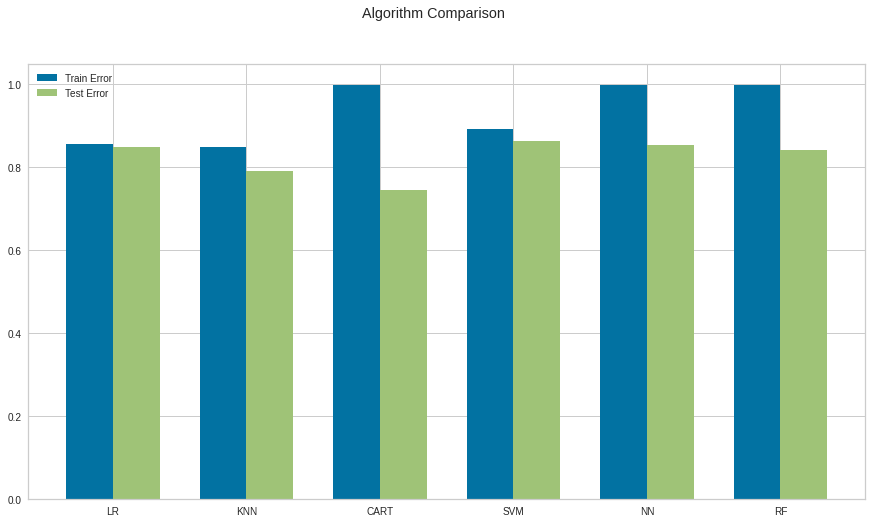

In [ ]:
# compare algorithms
from matplotlib import pyplot
fig = pyplot.figure()
ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

The best model with the highest accuracy is **Support Vector Machine(SVM)** with **85.79**% accuracy on test dataset. Logistic Regression performed good as well but we see overfitting problem with CART, NN and RF.

### LSTM model:

In [ ]:
### Create sequence
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(df_all['clean_text'])
sequences = tokenizer.texts_to_sequences(df_all['clean_text'])
X_LSTM = pad_sequences(sequences, maxlen=50)

In [ ]:
## Split the data into train and test
Y_LSTM = df_all["label"]
X_train_LSTM, X_test_LSTM, Y_train_LSTM, Y_test_LSTM = train_test_split(X_LSTM, \
                       Y_LSTM, test_size=validation_size, random_state=seed)

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
def create_model(input_length=50):
    model = Sequential()
    model.add(Embedding(20000, 300, input_length=50))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model    
model_LSTM = KerasClassifier(build_fn=create_model, epochs=3, verbose=1, validation_split=0.4)
model_LSTM.fit(X_train_LSTM, Y_train_LSTM)

Epoch 1/3
511/511 [==============================] - 138s 264ms/step - loss: 0.3561 - accuracy: 0.8405 - val_loss: 0.3040 - val_accuracy: 0.8729
Epoch 2/3
511/511 [==============================] - 135s 263ms/step - loss: 0.1890 - accuracy: 0.9241 - val_loss: 0.3237 - val_accuracy: 0.8606
Epoch 3/3
511/511 [==============================] - 134s 263ms/step - loss: 0.1161 - accuracy: 0.9525 - val_loss: 0.4235 - val_accuracy: 0.8540


In [ ]:
train_result_LSTM = accuracy_score(model_LSTM.predict(X_train_LSTM), Y_train_LSTM)
# Test results
test_result_LSTM = accuracy_score(model_LSTM.predict(X_test_LSTM), Y_test_LSTM)

In [ ]:
print("train result:", train_result_LSTM)
print("test result:", test_result_LSTM)

train result: 0.9259068879424291
test result: 0.8553071189925469


In [ ]:
confusion_matrix(model_LSTM.predict(X_test_LSTM), Y_test_LSTM)

array([[5424,  844],
       [ 845, 4560]])

### Compare all the models:

In [ ]:
train_results.append(train_result_LSTM);test_results.append(test_result_LSTM)
names.append("LSTM")

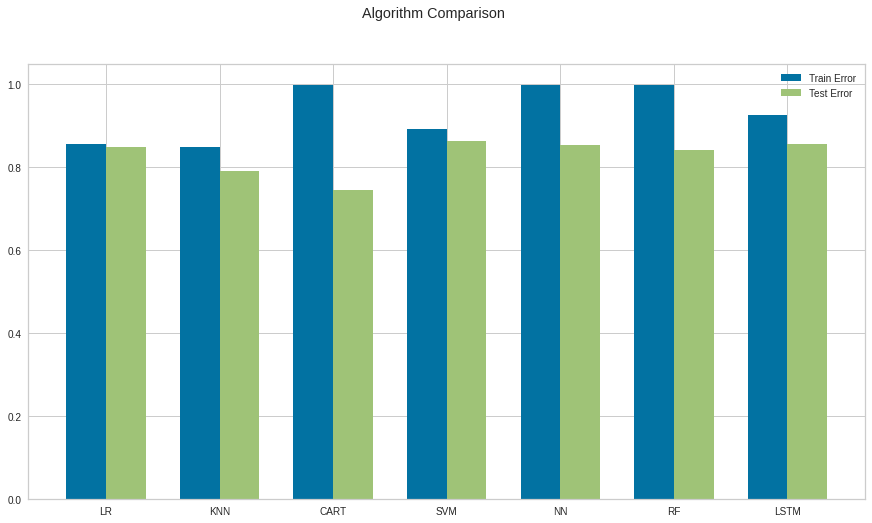

<Figure size 576x396 with 0 Axes>

In [ ]:
# compare algorithms
from matplotlib import pyplot
fig = pyplot.figure()
ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results,  width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()
plt.savefig('/content/drive/MyDrive/NLP/Depression_Detection/modeling/classification_comparision.png')

## Evaluate the performance:

*   **Accuracy:** the fraction of predictions the model got right.
*   **Confusion Matrix:** a summary table that breaks down the number of correct and incorrect predictions by each class.
*   **ROC:** a plot that illustrates the true positive rate against the false positive rate at various threshold settings. The area under the curve (AUC) indicates the probability that the classifier will rank a randomly chosen positive observation higher than a randomly chosen negative one.
*  **Precision:** the fraction of relevant instances among the retrieved instances.
*  **Recall:** the fraction of the total amount of relevant instances that were actually retrieved.



In [ ]:
def conf_matrix_acc(y_true, y_pred):
  ## Plot confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots()
  sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
  ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
  plt.yticks(rotation=0)
  print("=========================================")
  print(f'Accuracy score is : {accuracy_score(y_true, y_pred)}')
  print("=========================================")
  print("Detail:")
  print(skm.classification_report(y_true, y_pred))

In [ ]:
## Plot ROC and precision-recall curve
def roc_precision_auc():
  fig, ax = plt.subplots(nrows=1, ncols=2)
  ## Plot roc
  for i in range(len(classes)):
      fpr, tpr, thresholds = skm.roc_curve(y_test_array[:,i],  
                            probs[:,i])
      ax[0].plot(fpr, tpr, lw=3, 
                label='{0} (area={1:0.2f})'.format(classes[i], 
                                skm.auc(fpr, tpr))
                 )
  ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
  ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
            xlabel='False Positive Rate', 
            ylabel="True Positive Rate (Recall)", 
            title="Receiver operating characteristic")
  ax[0].legend(loc="lower right")
  ax[0].grid(True)

  ## Plot precision-recall curve
  for i in range(len(classes)):
    precision, recall, thresholds = skm.precision_recall_curve(
                y_test_array[:,i], probs[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  skm.auc(recall, precision))
              )
  ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
            ylabel="Precision", title="Precision-Recall curve")
  ax[1].legend(loc="best")
  ax[1].grid(True)
  plt.show()
  #plt.savefig('/content/drive/MyDrive/NLP/Depression_Detection/modeling/ROC_Precision_LR.png')
  #plt.savefig('/content/drive/MyDrive/NLP/Depression_Detection/modeling/ROC_Precision_SVM.png')  
  ## AUC score
  print(f'AUC score is : {skm.roc_auc_score(Y_test, probs[:,1])}')

## Support Vector Machine(SVM) with word embedding:

In [ ]:
nlp = en_core_web_lg.load()

In [ ]:
## word-embedding
all_vectors = pd.np.array([pd.np.array([token.vector for token in nlp(s)]).mean(axis=0) * pd.np.ones((300)) \
                           for s in df_all['clean_text']])

In [ ]:
# split out validation dataset for the end
Y= df_all["label"]
X = all_vectors

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
validation_size = 0.3
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'

In [ ]:
#Create a svm Classifier
clf = SVC(probability=True) 

In [ ]:
## Running the svm Classifier
   
# Full Training period
res = clf.fit(X_train, Y_train)
train_result = accuracy_score(res.predict(X_train), Y_train)
test_result = accuracy_score(res.predict(X_test), Y_test)

In [ ]:
print("train_result:", "test_resuld:", train_result, test_result, sep=" ")

train_result: test_resuld: 0.8922749302393891 0.8630172192238499


In [ ]:
## Save the Modle to file in the current working directory
SVM = "/content/drive/MyDrive/NLP/Depression_Detection/modeling/model_svm1.pkl"  

with open(SVM, 'wb') as file:  
    pickle.dump(clf, file)

In [ ]:
## Load the Model back from file
with open(SVM, 'rb') as file:  
    clf = pickle.load(file)

clf

SVC(probability=True)

Accuracy score is : 0.8630172192238499
Detail:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      6269
           1       0.86      0.84      0.85      5404

    accuracy                           0.86     11673
   macro avg       0.86      0.86      0.86     11673
weighted avg       0.86      0.86      0.86     11673



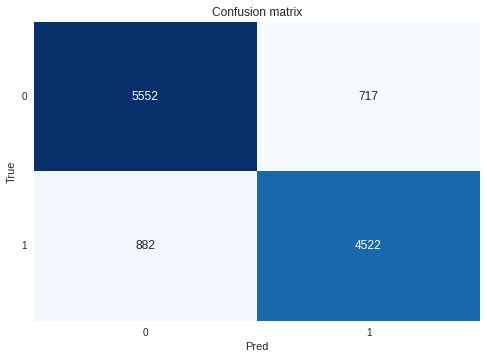

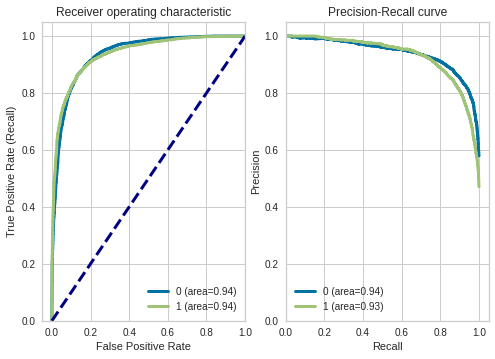

AUC score is : 0.9365111408468516


<Figure size 576x396 with 0 Axes>

In [ ]:
## Test results
## 
y_pred_svm = res.predict(X_test) 
classes = np.unique(Y_test.to_list())
y_test_array = pd.get_dummies(Y_test, drop_first=False).values
probs = res.predict_proba(X_test)
conf_matrix_acc(Y_test.to_list(),y_pred_svm)
roc_precision_auc()

## Exploring False positive and False negative:

In [ ]:
## creating lists of true values and predictions
y_test_1 = [x for x in y_test]
y_pred_lr_1 = [x for x in y_pred_lr]

In [ ]:
## Find the indices of wrong predictions
idx = [] 
for i in range(len(y_test_1)):
  if y_test_1[i] != y_pred_lr_1[i]:
    idx.append(i)
    i+=1

In [ ]:
print('There are", {} "wrong preditions", len(idx))

1157

In [ ]:
wrong_arr = cv.inverse_transform(X_test_tfidf[idx])

In [ ]:
## detokenize the wrong array
detokenized = [TreebankWordDetokenizer().detokenize(x) for x in wrong_arr]

In [ ]:
detokenized[:50]

['year paradox mood meet man later hospital dream cope bum bite',
 'one in headache give',
 'job',
 'walk visit use train station stair ride rainy perfect new mood month home explore exercise dark cold bus boosting antidote',
 'thomas stronger stain rob one let left know good go every day',
 'yupp using put hi hacked ashwin account abt',
 'shadow love healed ford embraced debbie becomes',
 'story short make long like difference',
 'text start side seen guy chick argument',
 'handle',
 'thought seeya',
 'stay positive jess',
 'take seriously ppl missing man lot laugh hilarity happy',
 'tea one made friend day brought',
 'year plus',
 'yawn tired heading daddy bed',
 'story life heatherbailey',
 'wan rich na live life famous coz',
 'would tila talk like know guess difficult choose child',
 'wanted loved love joy desired',
 'yurina sorry saying im',
 'wow quote pretty never life fwd end email dumb deep begin afraid',
 'without story reason always act',
 'fails else',
 'work wannamusic mf 

There is no specific patterns between false positive and false negative predictions.